In [1]:
#!jupyter nbconvert --to script SVM_Training.ipynb
from __future__ import print_function
import sys
import os
import numpy as np
import shutil
sys.path.insert(0, os.path.join('..', '..'))
import datetime

%matplotlib inline
!ls

args.json  Auswertung.ipynb  launcher.py  SVM_Training.html  SVM_Training.ipynb


# Settings

In [2]:
diff_poses = True
diff_pose_magnitude = True
temporal_extent = 2

In [3]:
import json
with open('args.json', 'r') as f:
    args = json.load(f)
print(json.dumps(args, indent=4, sort_keys=True))


{
    "diff_pose_magnitude": true, 
    "diff_poses": true, 
    "max_test": null, 
    "output-dir": "/media/sandro/Volume/Datasets/tumgaid/experiments/toy_exp", 
    "split_index": 10, 
    "svm_args": {
        "C": 0.001, 
        "kernel": "linear"
    }, 
    "temporal_extent": 1, 
    "tumgaid_args": {
        "include_scenes": [
            "b01", 
            "b02", 
            "n01", 
            "n02", 
            "s01", 
            "s02"
        ], 
        "load_flow": false, 
        "load_flow_options": {
            "load_patch_options": {
                "patch_size": 5
            }, 
            "load_patches": true, 
            "method": "dense"
        }, 
        "load_pose": true, 
        "load_pose_options": {
            "D": 2, 
            "body_keypoints_include_list": [
                "LAnkle", 
                "RAnkle", 
                "LKnee", 
                "RKnee", 
                "RHip"
            ]
        }, 
        "load_scene": false, 


In [8]:
diff_poses = args['diff_poses']
diff_pose_magnitude = args['diff_pose_magnitude']
temporal_extent = args['temporal_extent'] #will concatenate +- N frame features together into a single feature vector
output_folder = args['output-dir']

split_index = args['split_index']
max_test = args['max_test']

svm_args = args['svm_args']

## TUMGAID example
tumgaid_args = args['tumgaid_args']
shutil.copy('args.json', output_folder)

In [7]:
real_output_folder = output_folder
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        pass
        #if exc.errno == errno.EEXIST and os.path.isdir(path):
        #    pass
        #else:
        #    raise
mkdir_p(real_output_folder)

## creating output folder based on current timestamp

# Dataset generation

In [9]:
from gait_analysis.Datasets import TumGAID_Dataset
from gait_analysis.utils.openpose_utils import Pose, maybe_subtract_poses
from gait_analysis import settings as S
from gait_analysis.utils.iterators import *
tg_dset = TumGAID_Dataset(S.tumgaid_root,
                          S.tumgaid_preprocessing_root,
                          S.tumgaid_annotations_root,
                          tumgaid_args)

# Split dataset into Train and Validation

In [10]:
import sklearn
from sklearn.model_selection import train_test_split

p_nums_train = tg_dset.p_nums[:split_index]
if max_test:
    p_nums_test = tg_dset.p_nums[split_index:(split_index + max_test)]
else: 
    p_nums_test = tg_dset.p_nums[split_index:]
def create_idx_list(p_nums_list):
    idx_list = []
    for i, dset_item in enumerate(tg_dset.dataset_items):
        p_num, _ = dset_item
        if p_num in p_nums_list:
            idx_list.append(i)
    return idx_list
idx_train = create_idx_list(p_nums_train)
idx_test = create_idx_list(p_nums_test)

print(idx_train)
print(idx_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]


# Training Loop

In [11]:
def annotations_to_targets(annotations):
    '''
    IN_THE_AIR == TRUE
    '''
    a = annotations.left_foot.values == 'IN_THE_AIR'    
    return a * 1

def flatten_features(single_frame_feature):
    return np.ravel(single_frame_feature)

def yield_kXY(temporal_extent, flat_features, targets):
    '''
    yields an X and a Y given a list of flat_features and a list of targets.
    The temporal_extent will concatenate neighboring frames into a single features vector.
    The target will be the center frame of the concatenate extent
    
    yields index k of the sequence of flat_features
    concatenated features X
    target Y
    '''
    for k in range(temporal_extent, len(flat_features) - temporal_extent):
        x_start, x_end = np.array([-temporal_extent, temporal_extent]) + k
        X = np.hstack(flat_features[x_start:x_end + 1])
        X = np.reshape(X, (1, -1))
        Y = targets[k]
        yield k, X, Y

## little debugging snippet

In [12]:
idx = 0
features, annotations = tg_dset[idx]
targets = annotations_to_targets(annotations)
list_of_single_frame_features = features['pose_keypoints']
list_of_single_frame_features = maybe_subtract_poses(list_of_single_frame_features, 
                                                     diff_poses, 
                                                     diff_pose_magnitude)
flat_features = list(map(flatten_features, list_of_single_frame_features))

X_list = []
Y_list = []
for _, X, Y in yield_kXY(temporal_extent, flat_features, targets):
    X_list.append(X)
    Y_list.append(Y)

/home/sandro/anaconda2/envs/gait_27/lib/python2.7/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [13]:
X_list[0].shape

(1, 15)

# Initialize Model

In [14]:
#from gait_analysis.Models.OtherModels import SVMModel
from gait_analysis.Models.BaseModels import AbstractGaitModel
from gait_analysis.Models.OtherModels import SVMModel
from sklearn import svm

svm_obj = svm.SVC(**svm_args)
model = SVMModel(svm_obj)

In [15]:
for idx in idx_train:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    list_of_single_frame_features = features['pose_keypoints']
    list_of_single_frame_features = maybe_subtract_poses(list_of_single_frame_features, 
                                                         diff_poses,
                                                         diff_pose_magnitude)
    flat_features = list(map(flatten_features, list_of_single_frame_features))
    for _, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        model.train(X, Y)

In [16]:
model._concat_features()

In [17]:
print(model.feature_list.shape)
print(model.target_list.shape)

(3797, 15)
(3797,)


## Finish training and fit model

In [18]:
model.finish_training() # actually fit svm

## evaluate

In [19]:
import pandas as pd
result_dict = {}
for idx in idx_test:
    features, annotations = tg_dset[idx]
    targets = annotations_to_targets(annotations)
    list_of_single_frame_features = features['pose_keypoints']
    list_of_single_frame_features = maybe_subtract_poses(list_of_single_frame_features, diff_poses, diff_pose_magnitude)
    flat_features = list(map(flatten_features, list_of_single_frame_features))
    
    sequence_output = {
        'frame_id' : [],
        'target' : [],
        'prediction' : []
    }
    for k, X, Y in yield_kXY(temporal_extent, flat_features, targets):
        prediction = model.svm_obj.predict(X)                
        sequence_output['frame_id'].append(k)
        sequence_output['target'].append(Y)
        sequence_output['prediction'].append(prediction)
        
    result_dict[idx] = sequence_output

               precision    recall  f1-score   support

ON_THE_GROUND       0.90      0.95      0.93      1292
   IN_THE_AIR       0.90      0.82      0.86       726

  avg / total       0.90      0.90      0.90      2018



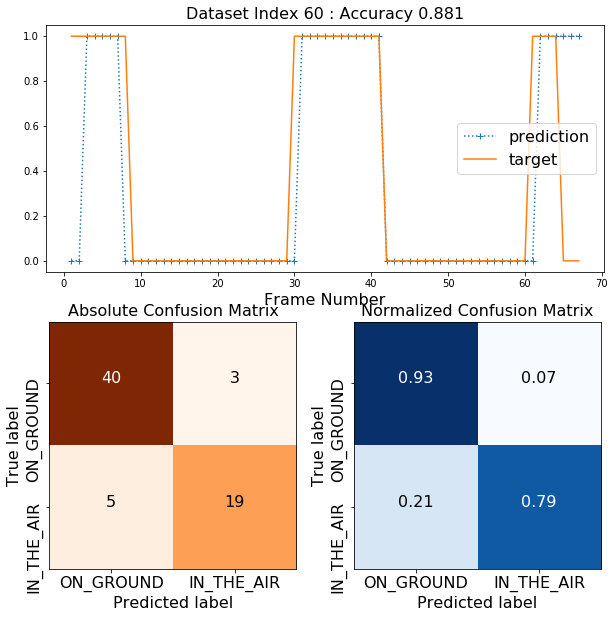

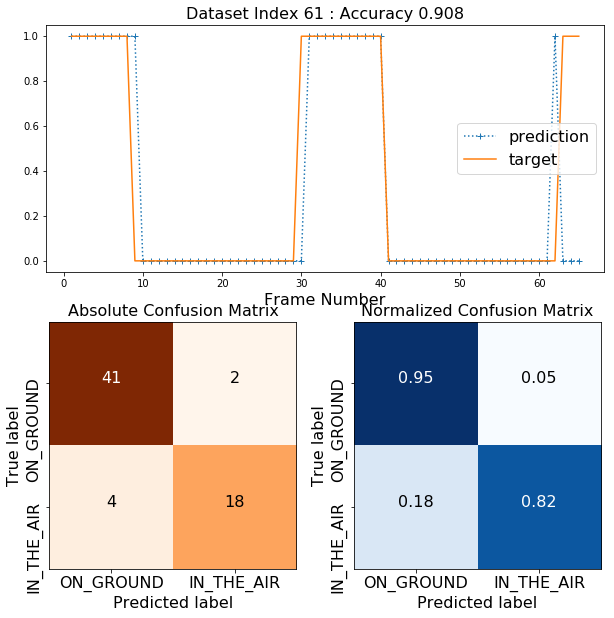

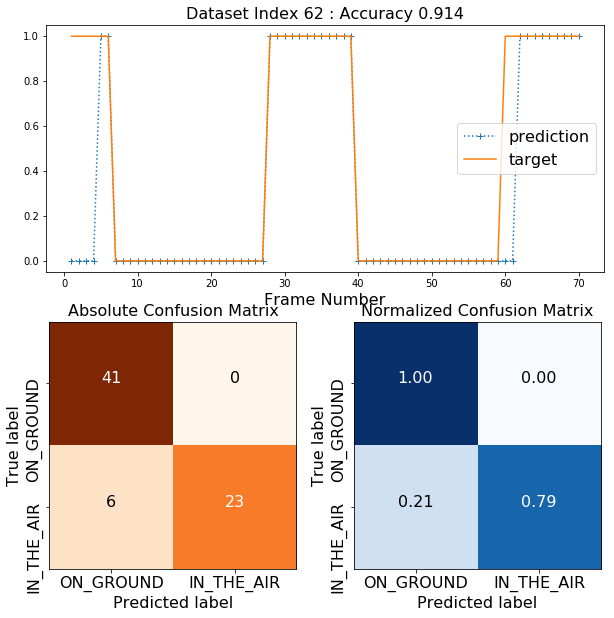

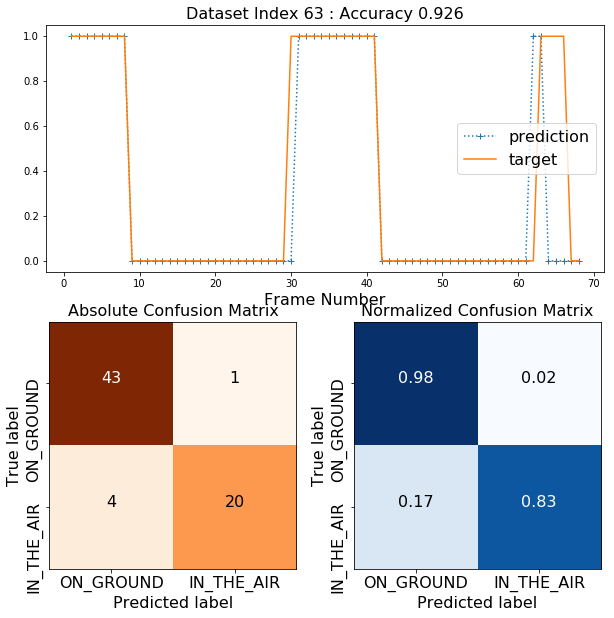

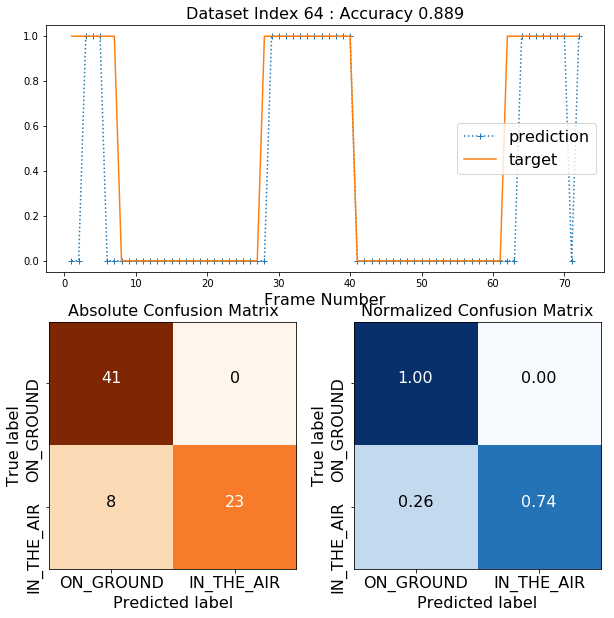

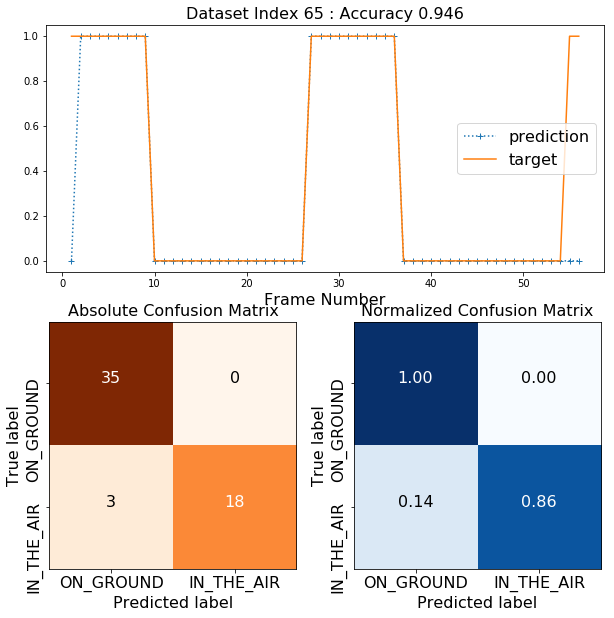

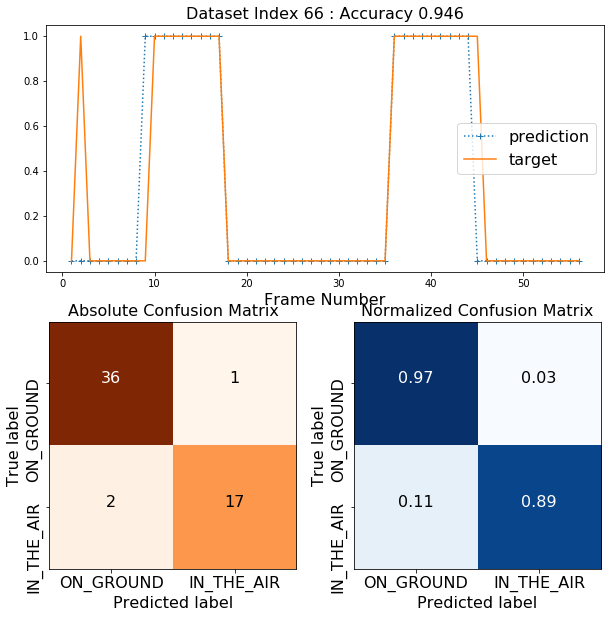

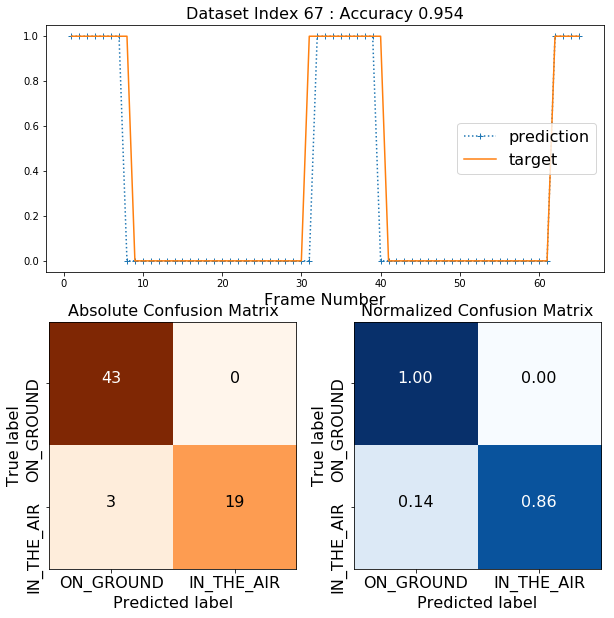

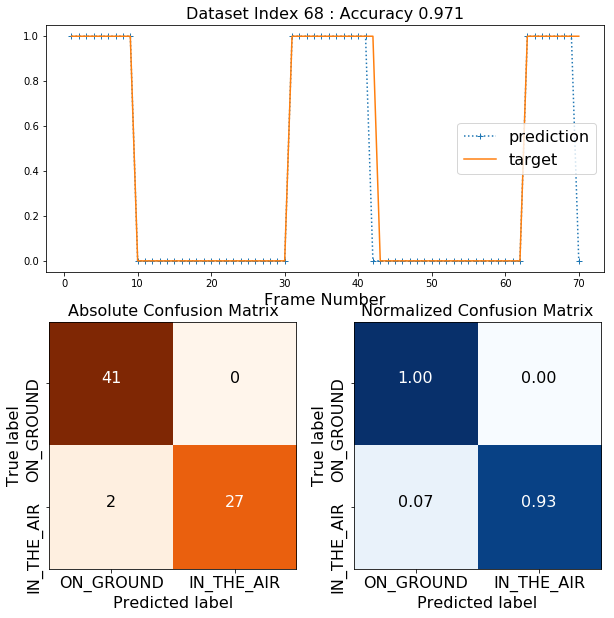

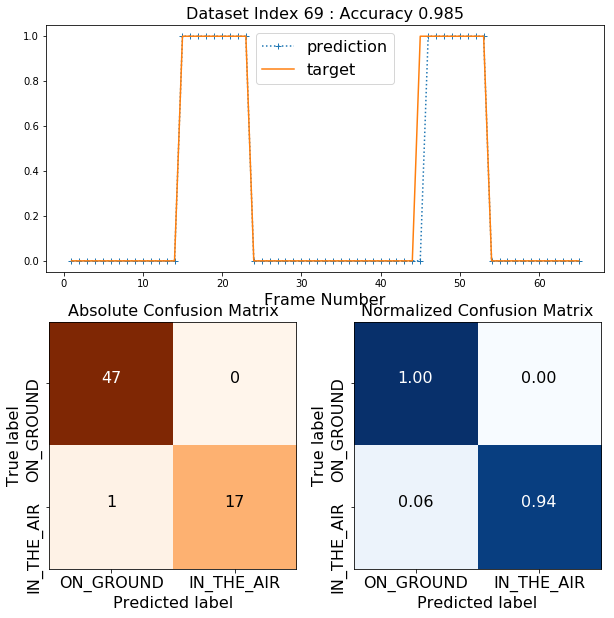

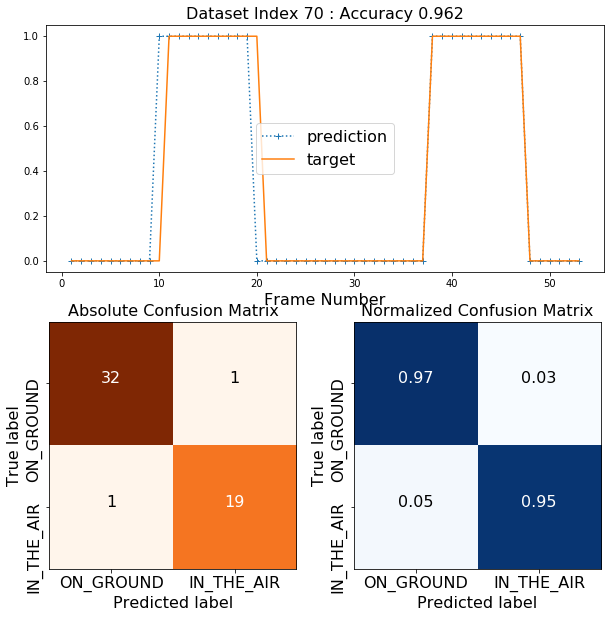

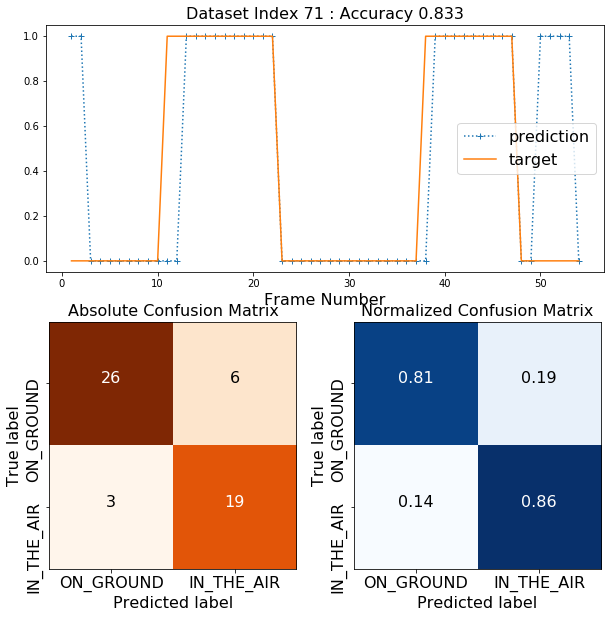

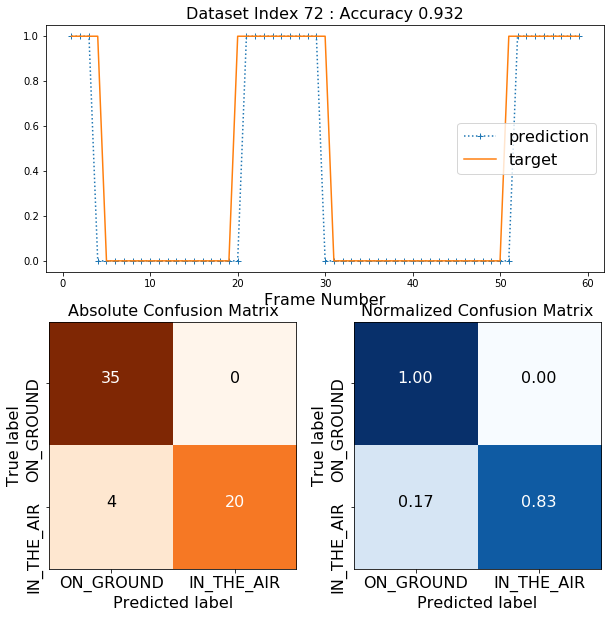

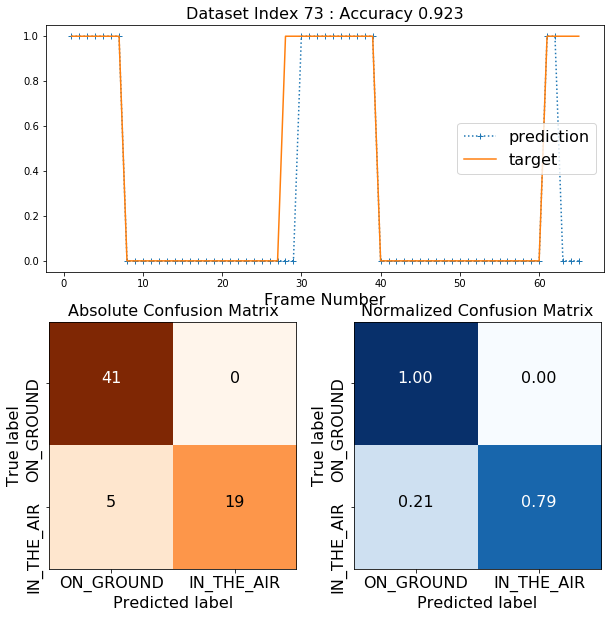

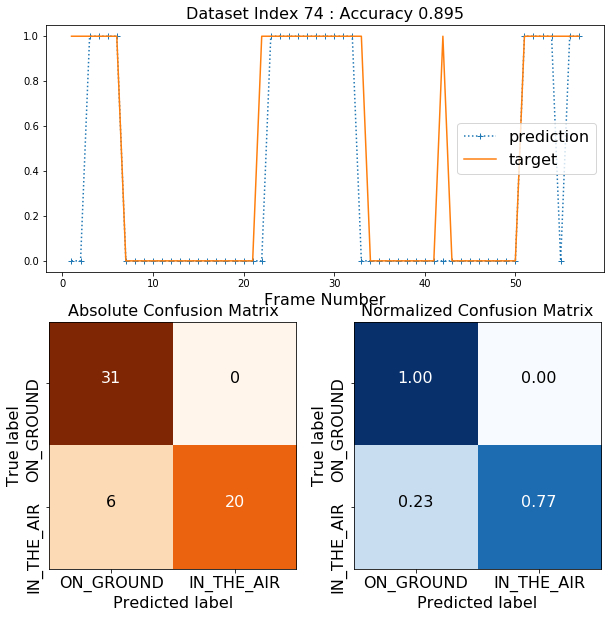

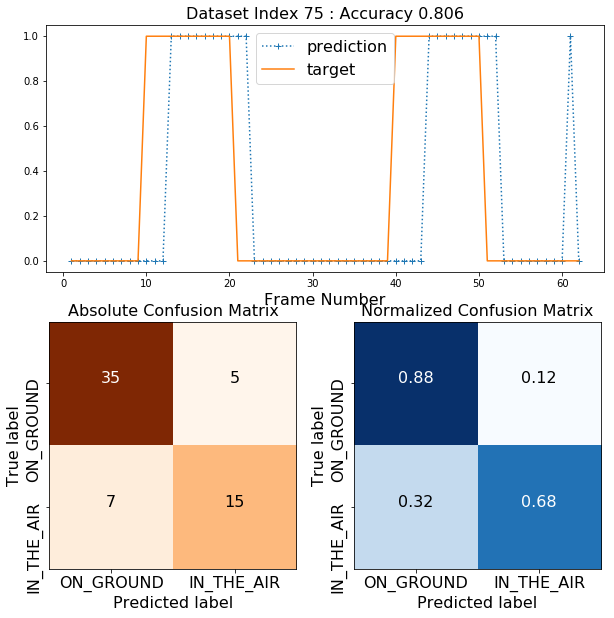

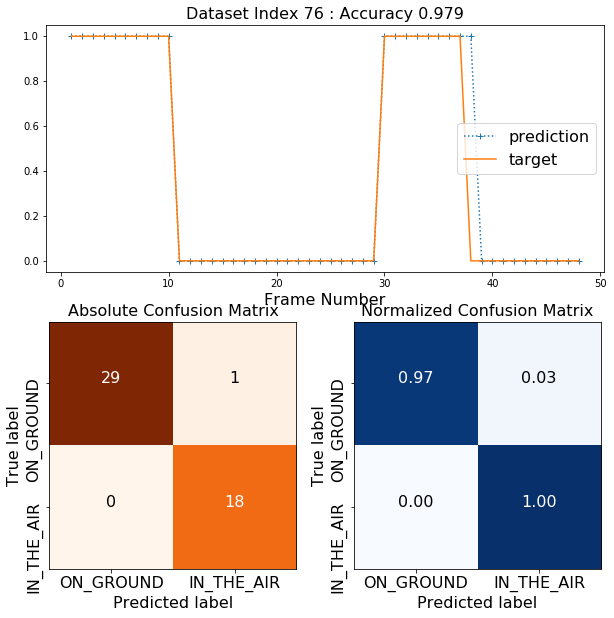

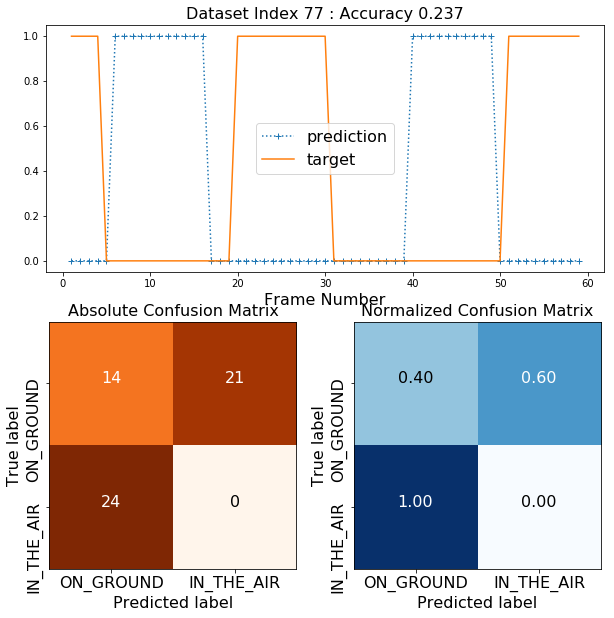

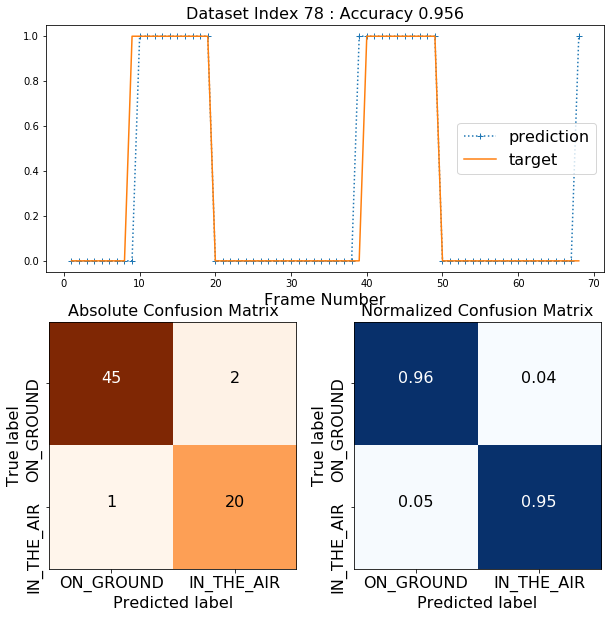

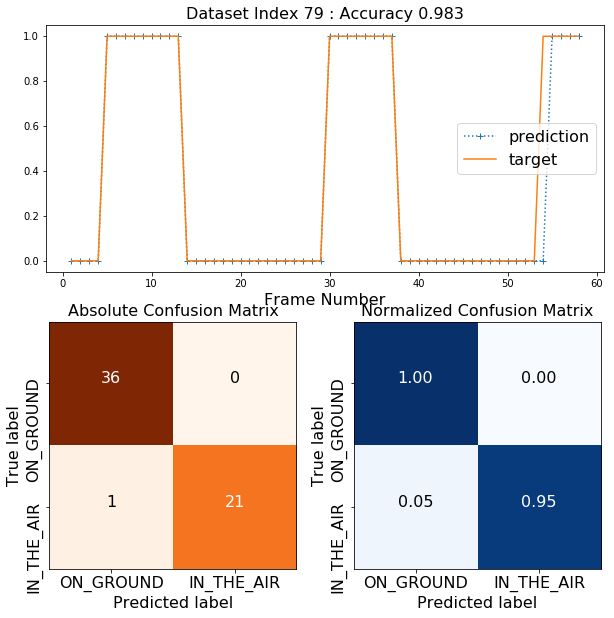

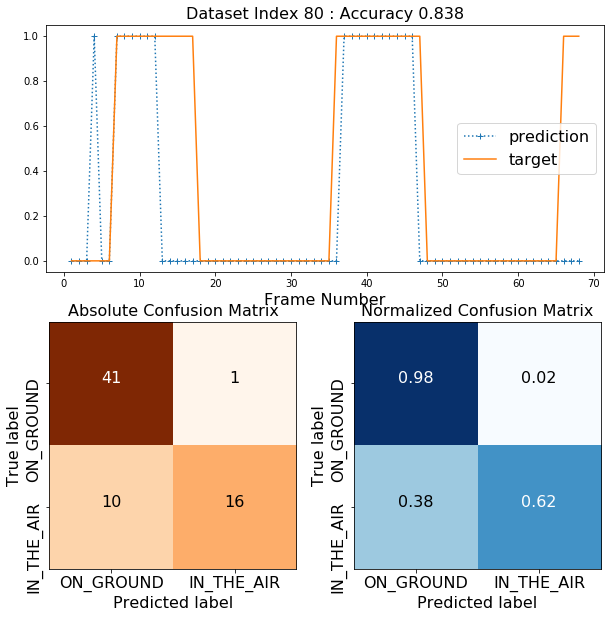

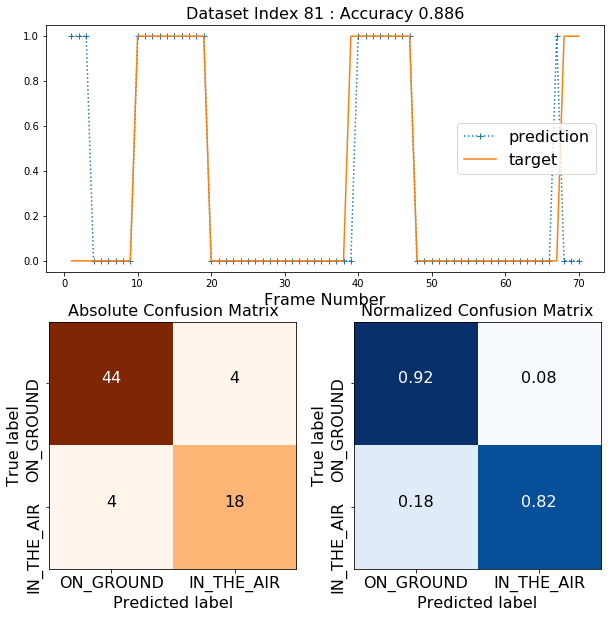

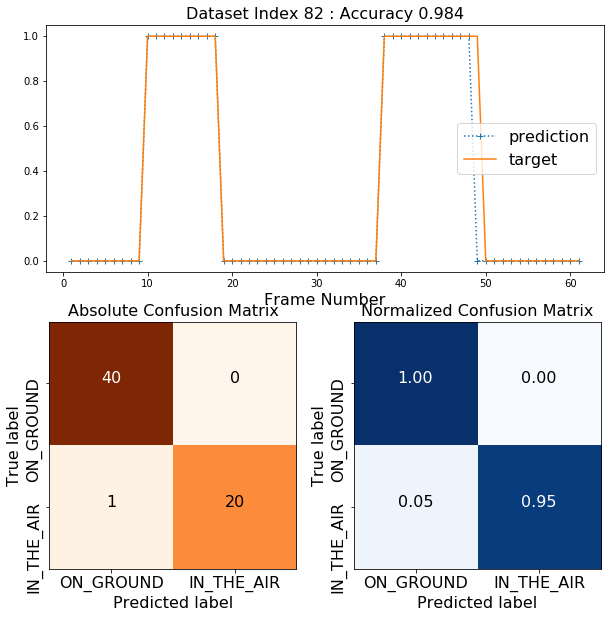

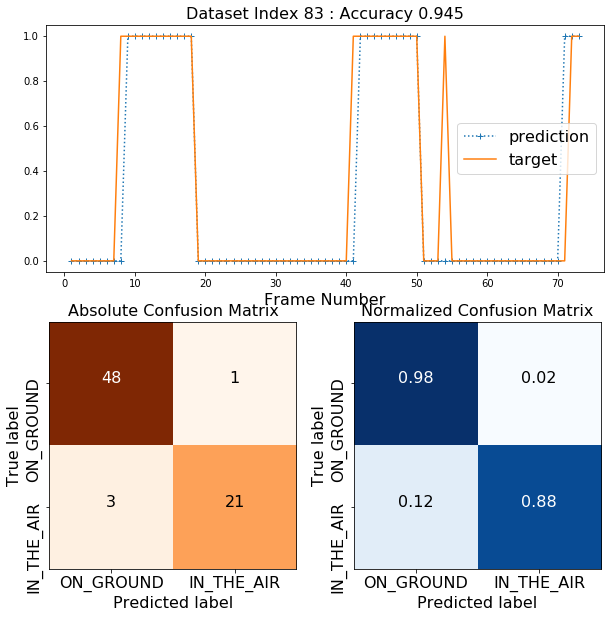

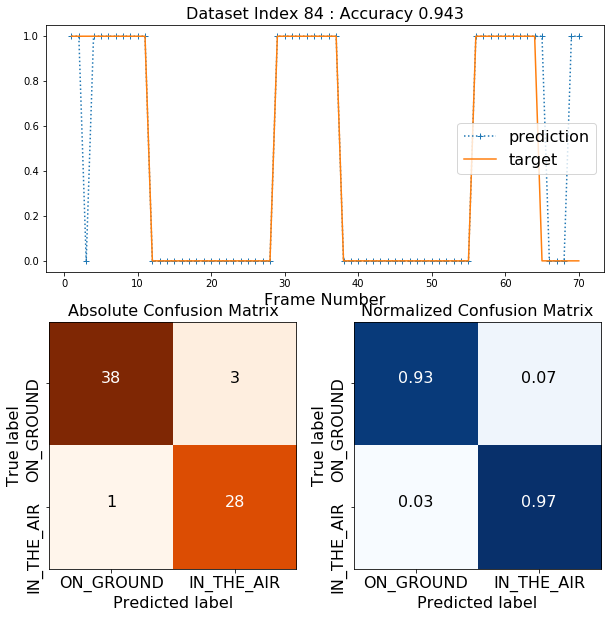

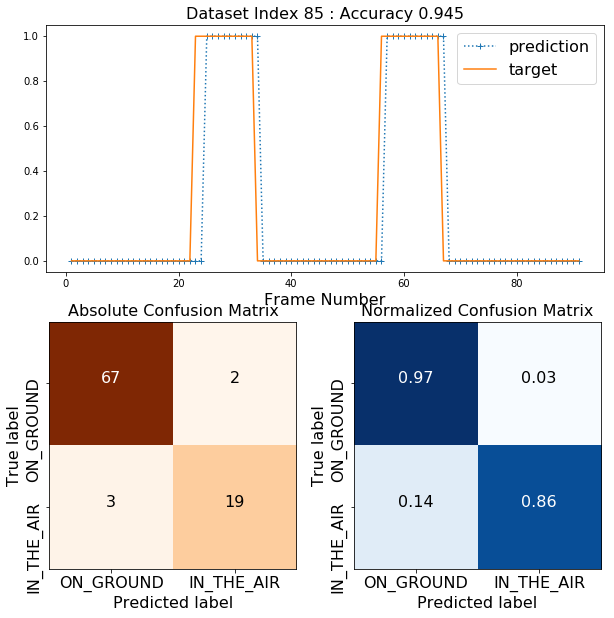

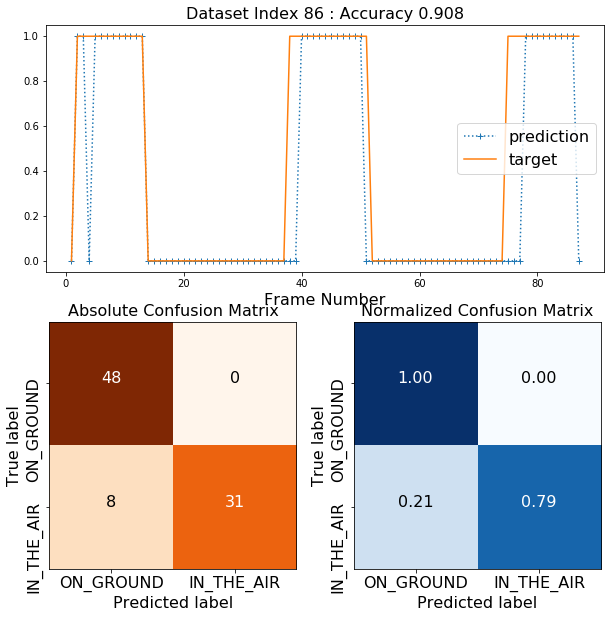

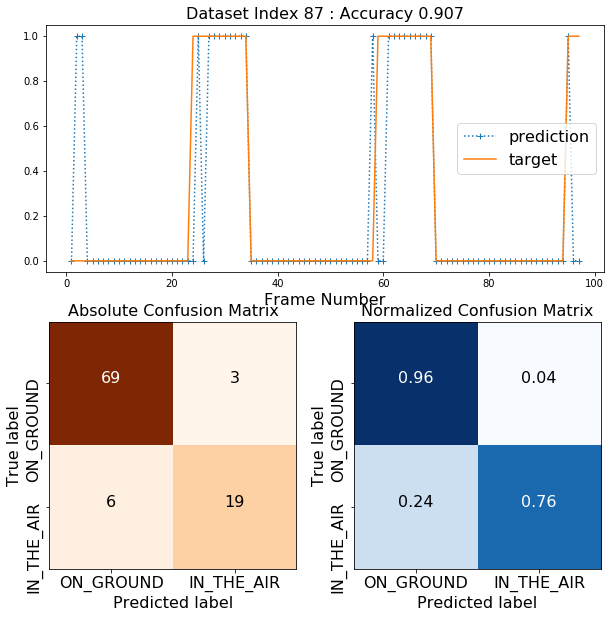

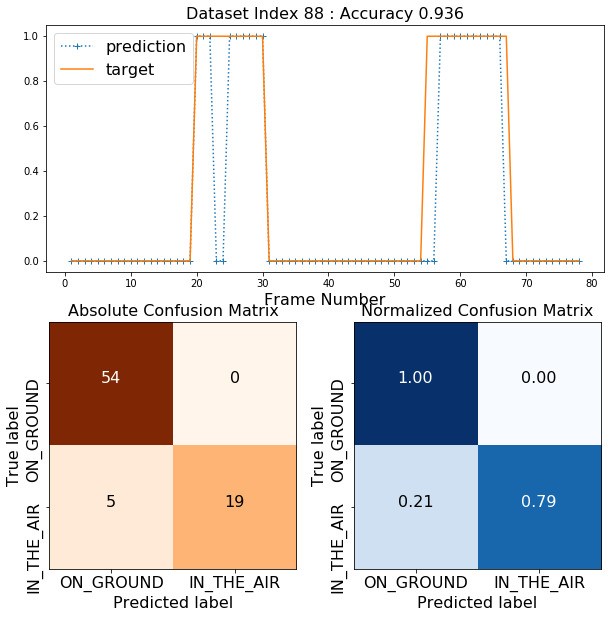

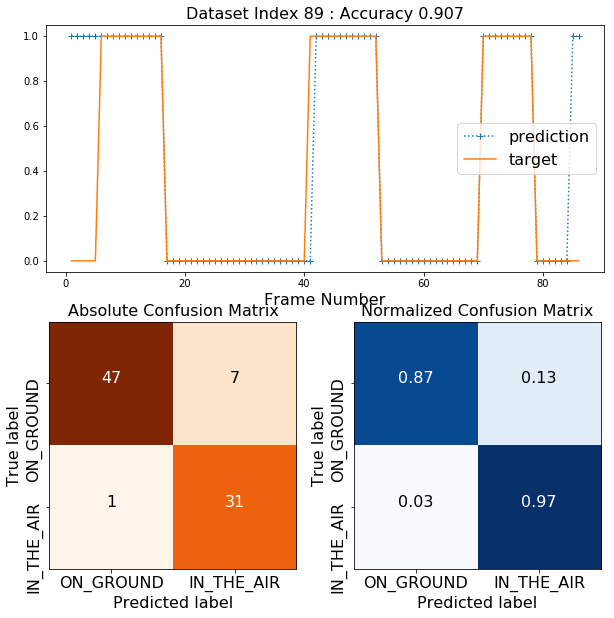

In [54]:
from matplotlib import pyplot as plt
import pickle as pl
df = pd.DataFrame(result_dict)
# df.to_excel(os.path.join(real_output_folder, 'results.xlsx'))
for r in df.columns:
    df[r].prediction = np.squeeze(df[r].prediction).astype(np.float)
    df[r].target = np.squeeze(df[r].target, np.int)
    df[r].frame_id = np.squeeze(df[r].frame_id, np.int)
df.to_pickle(os.path.join(real_output_folder, 'results.pickle'))
data_frame = df

linestyles = ['-', '-.', ':']
markers = ["+", "o", "*", "s", ".", "1", "2", "3", "4"]
markersizecolors = [(4, "white"), (8, "red"), (12, "yellow"), (16, "lightgreen")]

# TODO import this from plotting tools
def plot_cm(ax, cm, classes=np.arange(2), normalize=False):
    font_size = 16
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title('Normalized Confusion Matrix', fontsize=font_size)
    else:
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
        ax.set_title('Absolute Confusion Matrix', fontsize=font_size)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize=font_size)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, fontsize=font_size)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=font_size)   
        
    ax.set_ylabel('True label', fontsize=font_size)
    ax.set_xlabel('Predicted label', fontsize=font_size)
    return ax
        
def plot_single_sequence(sequence_id, data_frame):    
    font_size = 16
    a = data_frame[sequence_id]
    x = a['frame_id']
    target = a['target']
    prediction = a['prediction']
    accuracy = sklearn.metrics.accuracy_score(target, prediction)    
        
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, fig=fig)
    ax2 = plt.subplot2grid((2, 2), (1, 0), fig=fig)
    ax3 = plt.subplot2grid((2, 2), (1, 1), fig=fig)
    ax = ax1
    
    ax.plot(x, prediction, label='prediction', linestyle=linestyles[2], marker=markers[0])
    ax.plot(x, target, label='target')
    
    ax.legend(fontsize=font_size)
    ax.set_xlabel('Frame Number', fontsize=font_size)
    ax.set_title('Dataset Index {} : Accuracy {:.03f}'.format(sequence_id, accuracy), fontsize=font_size)
        
    ax = ax2
    cm = sklearn.metrics.confusion_matrix(target, prediction)
    ax = plot_cm(ax, cm, classes=['ON_GROUND', 'IN_THE_AIR'])
    
    ax = ax3
    ax = plot_cm(ax, cm, normalize=True, classes=['ON_GROUND', 'IN_THE_AIR'])
    return fig, [ax1, ax2, ax3]


#def print_summary(data_frame):
cols = data_frame.columns    
all_targets = np.hstack([np.array(data_frame[idx]['target']) for idx in cols])
all_predictions = np.hstack([np.array(data_frame[idx]['prediction']).squeeze()] for idx in cols).squeeze()
print(sklearn.metrics.classification_report(all_targets, all_predictions, target_names=['ON_THE_GROUND', 'IN_THE_AIR']))

with open(os.path.join(real_output_folder, 'classification_report.txt'), 'w') as f:
    print(sklearn.metrics.classification_report(all_targets, all_predictions, target_names=['ON_THE_GROUND', 'IN_THE_AIR']), file=f)


for idx in df.columns:
    fig, ax = plot_single_sequence(idx, df)
    plt.savefig(os.path.join(real_output_folder, 'dataset_index_{:03d}.png'.format(idx)))
    pl.dump(fig, file(os.path.join(real_output_folder, 'dataset_index_{:03d}.pickle'.format(idx)), 'w'))

# save this file in the output folder

In [17]:
from subprocess import call
args = ['jupyter', 'nbconvert', 
       '--to', 'html', 
       '--output-dir', real_output_folder,
       'SVM_Training.ipynb']
#call(args)